In [1]:
import sys, os

import numpy as np
from umap import UMAP
import time
import torch
import matplotlib.pyplot as plt
import pandas as pd  
import scanpy as sc
import scipy.sparse as sps
import scipy.io as sio
# import scipy.sparse as sp
from os.path import join
import h5py
import warnings
import gc

import scmomat 

plt.rcParams["font.size"] = 10
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
def set_col2cat(ad, cols=[]):
    for col in cols:
        ad.obs[col] = ad.obs[col].astype('category')

def unify_colors(queries, color_key, ref_color_dict):
    for q in queries:
        q.obs[color_key] = q.obs[color_key].astype('category')
        q.uns[f'{color_key}_colors'] = [ref_color_dict[_] for _ in q.obs[color_key].cat.categories]
    return queries

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def wrap_warn_comp_plot(ads, basis, colors, figw=5, figh=4, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, color in enumerate(colors):
            _, axes = plt.subplots(1, len(ads), figsize=(figw*len(ads), figh))
            for j, ad in enumerate(ads):
                sc.pl.embedding(ad, basis=basis, color=color, ax=axes[j], show=False, **kwargs)
            plt.show()
            
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

from scib.metrics import lisi
def eval_lisi(
        adata,
        batch_keys=['domain', 'batch'],
        label_keys = ['gt'],
        use_rep='X_emb', use_neighbors=False,
    ):
    res = {}
    for key in batch_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.ilisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_iLISI'] = _lisi
    for key in label_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.clisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            batch_key=None,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_cLISI'] = _lisi
    df = pd.DataFrame.from_dict(res, orient='index').T
    # df.columns = [_+'_LISI' for _ in df.columns]
    return df

def eval_ads(ads, ref_key, src_key):
    aris = []
    for ad in ads:
        aris.append(adjusted_rand_score(ad.obs[src_key], ad.obs[ref_key]))
    return aris

from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
def eval_labelTransfer(ad1, ad2, use_rep, lab_key, knn=10):
     with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        neigh1 = KNeighborsClassifier(n_neighbors=knn)
        neigh1.fit(ad1.obsm[use_rep], ad1.obs[lab_key].to_list())
        pr_lab2 = neigh1.predict(ad2.obsm[use_rep])
        f1_1 = f1_score(ad2.obs[lab_key].values, pr_lab2, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        # acc1 = (pr_lab2 == ad2.obs[lab_key].values).mean()
    
        neigh2 = KNeighborsClassifier(n_neighbors=knn)
        neigh2.fit(ad2.obsm[use_rep], ad2.obs[lab_key].to_list())
        pr_lab1 = neigh2.predict(ad1.obsm[use_rep])
        # acc2 = (pr_lab1 == ad1.obs[lab_key].values).mean()
        f1_2 = f1_score(ad1.obs[lab_key].values, pr_lab1, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        return (f1_1+f1_2)/2


In [3]:
def split_ob(ads, ad_ref, ob='obs', key='emb2'):
    len_ads = [_.n_obs for _ in ads]
    if ob=='obsm':
        split_obsms = np.split(ad_ref.obsm[key], np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obsms):
            ad.obsm[key] = v
    else:
        split_obs = np.split(ad_ref.obs[key].to_list(), np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obs):
            ad.obs[key] = v
    
def subset_ad(ad, subset_index):
    ad = ad[subset_index].copy()
    return ad

def flip_coords(ads):
    for ad in ads:
        ad.obsm['spatial'] = -1 * ad.obsm['spatial']
        ad.obsm['spatial'] = ad.obsm['spatial'][:, ::-1]

def reorder(ad1, ad2):
    shared_barcodes = ad1.obs_names.intersection(ad2.obs_names)
    ad1 = ad1[shared_barcodes].copy()
    ad2 = ad2[shared_barcodes].copy()
    return ad1, ad2

def load_peak_expr(_dir):
    data = sio.mmread(join(_dir, 'data.mtx'))
    cname = pd.read_csv(join(_dir, 'barcode.csv'), index_col=0)['x'].to_list()
    feat = pd.read_csv(join(_dir, 'feat.csv'), index_col=0)['x'].to_list()
    ad = sc.AnnData(sps.csr_matrix(data.T))
    ad.obs_names = cname
    ad.var_names = feat
    return ad


### load dataset

In [4]:
data_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+atac/'

df_mult_rna = pd.read_csv(join(data_dir, 'rna+atac/GSM6204636_MouseBrain_20um_matrix.tsv'), sep='\t')
df_mult_rna_spatial_pos = pd.read_csv(join(data_dir, 'rna+atac/GSM6204623_MouseBrain_20um_spatial_rna_part/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_rna = sc.AnnData(df_mult_rna.T, obsm={'spatial': df_mult_rna_spatial_pos.loc[df_mult_rna.columns, [2, 3]].values})

ad_mult_atac = load_peak_expr(join(data_dir, 'rna+atac/GSM6204623_MouseBrain_20um_peak_data'))
df_mult_atac_spatial = pd.read_csv(join(data_dir, 'rna+atac/GSM6204623_MouseBrain_20um_spatial_rna_part/tissue_positions_list.csv'), index_col=0, header=None)
ad_mult_atac.obsm['spatial'] = df_mult_atac_spatial.loc[ad_mult_atac.obs_names, [2, 3]].values
ad_mult_rna, ad_mult_atac = reorder(ad_mult_rna, ad_mult_atac)

df_rna = pd.read_csv(join(data_dir, 'rna+atac/GSM6753041_MouseBrain_20um_repATAC_matrix.tsv'), sep='\t')
df_rna_spatial = pd.read_csv(join(data_dir, 'rna+atac/GSM6753041_MouseBrain_20um_repATAC_spatial/tissue_positions_list.csv'), index_col=0, header=None)
ad_rna = sc.AnnData(df_rna.T, obsm={'spatial': df_rna_spatial.loc[df_rna.columns, [2, 3]].values})

ad_atac = load_peak_expr(join(data_dir, 'atac/peak_data'))
df_atac_spatial = pd.read_csv(join(data_dir, 'atac/P21_brain_spatial/tissue_positions_list.csv'), index_col=0, header=None)
ad_atac.obsm['spatial'] = df_atac_spatial.loc[ad_atac.obs_names, [2, 3]].values

ad_atac.layers['counts'] = ad_atac.X.copy()
ad_rna.layers['counts'] = ad_rna.X.copy()
ad_mult_rna.layers['counts'] = ad_mult_rna.X.copy()
ad_mult_atac.layers['counts'] = ad_mult_atac.X.copy()

shared_gene = ad_mult_rna.var_names.intersection(ad_rna.var_names)
ad_mult_rna = ad_mult_rna[:, shared_gene].copy()
ad_rna = ad_rna[:, shared_gene].copy()
assert (ad_mult_atac.var_names == ad_atac.var_names).all()

ad_mult_rna.obs_names = [f'mult-{_}' for _ in ad_mult_rna.obs_names]
ad_mult_atac.obs_names = [f'mult-{_}' for _ in ad_mult_atac.obs_names]
ad_rna.obs_names = [f'rna-{_}' for _ in ad_rna.obs_names]
ad_atac.obs_names = [f'atac-{_}' for _ in ad_atac.obs_names]

ad_mult_rna.obs['src'] = ['mult']*ad_mult_rna.n_obs
ad_mult_atac.obs['src'] = ['mult']*ad_mult_atac.n_obs
ad_rna.obs['src'] = ['rna']*ad_rna.n_obs
ad_atac.obs['src'] = ['atac']*ad_atac.n_obs

ad_mult_rna.obsm['spatial'][:, 0] = -1 * ad_mult_rna.obsm['spatial'][:, 0]
ad_rna.obsm['spatial'][:, 1] = -1 * ad_rna.obsm['spatial'][:, 1]
ad_mult_atac.obsm['spatial'][:, 0] = -1 * ad_mult_atac.obsm['spatial'][:, 0]
ad_atac.obsm['spatial'][:, 1] = -1 * ad_atac.obsm['spatial'][:, 1]

/tmp/ipykernel_3575/2033349258.py:5: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad_mult_rna = sc.AnnData(df_mult_rna.T, obsm={'spatial': df_mult_rna_spatial_pos.loc[df_mult_rna.columns, [2, 3]].values})
/tmp/ipykernel_3575/4188962916.py:31: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = sc.AnnData(sps.csr_matrix(data.T))
/tmp/ipykernel_3575/2033349258.py:14: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get 

In [5]:
ad_rna_all = sc.concat([ad_mult_rna, ad_rna])
ad_atac_all = sc.concat([ad_mult_atac, ad_atac])

sc.pp.highly_variable_genes(ad_rna_all, flavor='seurat_v3', n_top_genes=10000, batch_key='src')
hvg_names = ad_rna_all.var.query('highly_variable').index.to_numpy()

In [6]:
# ac.pp.tfidf(ad_atac_all, scale_factor=1e4)
sc.pp.highly_variable_genes(ad_atac_all, flavor='seurat_v3', n_top_genes=100000, batch_key='src')
hvp_names = ad_atac_all.var.query('highly_variable').index.to_numpy()

In [33]:
# def saveR(ad, name, dir):
#     sio.mmwrite(join(dir, f'{name}_mat.mtx'), sps.csr_matrix(ad.X))
#     pd.DataFrame(ad.obs_names).to_csv(join(dir, f'{name}_cname.csv'))
#     pd.DataFrame(ad.var_names).to_csv(join(dir, f'{name}_feat.csv'))

# saveR(ad_mult_rna[:, hvg_names], 'bridge_rna', join(data_dir, 'R_data'))
# saveR(ad_mult_atac[:, hvp_names], 'bridge_atac', join(data_dir, 'R_data'))
# saveR(ad_rna[:, hvg_names], 'test_rna', join(data_dir, 'R_data'))
# saveR(ad_atac[:, hvp_names], 'test_atac', join(data_dir, 'R_data'))

### prepare count inputs

In [11]:
# READ IN THE COUNT MATRICES
counts_rnas = []
for adi in [ad_mult_rna, ad_rna, None]:
    if adi is not None:
        count = scmomat.preprocess(adi[:, hvg_names].X, modality = "RNA", log = False)
        counts_rnas.append(count)
    else:
        counts_rnas.append(None)

counts_atacs = []
for adi in [ad_mult_atac, None, ad_atac]:
    if adi is not None:
        count = scmomat.preprocess(adi[:, hvp_names].X.A, modality = "ATAC", log = False)
        counts_atacs.append(count)
    else:
        counts_atacs.append(None)

In [15]:
# CREATE THE COUNTS OBJECT
n_batches = 3
feats_name = {"rna": hvg_names, "atac": hvp_names}
counts = {"feats_name": feats_name, "nbatches": n_batches, "rna":counts_rnas, "atac": counts_atacs}

### step 2: training scmomat

Input sanity check...
Finished.
Epoch 1, Validating Loss: 66.4238
	 loss reconstruction: 0.05642
	 loss regularization: 1.00000
Epoch 1000, Validating Loss: 51.8438
	 loss reconstruction: 0.05184
	 loss regularization: 0.00001
Epoch 2000, Validating Loss: 51.4822
	 loss reconstruction: 0.05148
	 loss regularization: 0.00003
Epoch 3000, Validating Loss: 51.3172
	 loss reconstruction: 0.05131
	 loss regularization: 0.00073
Epoch 4000, Validating Loss: 51.2020
	 loss reconstruction: 0.05119
	 loss regularization: 0.00075
running time: 359.8680729866028


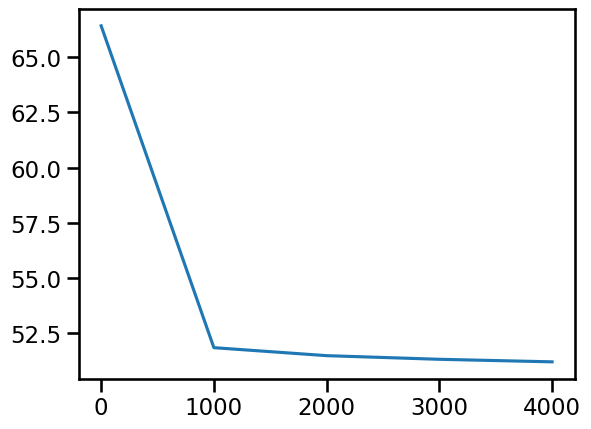

In [16]:
# #------------------------------------------------------------------------------------------------------------------------------------
# # NOTE: Number of latent dimensions, key hyper-parameter, 20~30 works for most of the cases.
K = 50
lamb = 0.01 
T = 4000     
interval = 1000
batch_size = 0.1
lr = 1e-2
seed = 0
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# #------------------------------------------------------------------------------------------------------------------------------------

start_time = time.time()
model = scmomat.scmomat_model(counts = counts, K = K, batch_size = batch_size, interval = interval, lr = lr, lamb = lamb, seed = seed, device = device)
losses = model.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

x = np.linspace(0, T, int(T/interval)+1)
plt.plot(x, losses)

#### inference

In [17]:
# umap_op = UMAP(n_components = 2, n_neighbors = 30, min_dist = 0.2, random_state = 0) 

if True:
    zs = model.extract_cell_factors()
    np.save('./outputs/MB_RNA+ATAC/zs.npy', zs)
else:
    zs = np.load('./outputs/MB_RNA+ATAC/zs.npy', allow_pickle=True)
    
# x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

/home/xuhua/xuhua_disco/miniforge3/envs/bento/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [18]:
# read in the ground truth labels
# NOTE: Plot the result before post-processing
# labels = [ad_bridge_rna.obs.Combined_Clusters_annotation, ad_test_rna.obs.Combined_Clusters_annotation, ad_test_atac.obs.Combined_Clusters_annotation]
batches = ['mult']*ad_mult_rna.shape[0] + ['rna']*ad_rna.shape[0] + ['atac']*ad_atac.shape[0]

### eval results

In [20]:
ad_mosaic = sc.AnnData(np.vstack(zs), obsm={"X_emb":np.vstack(zs)})
ad_mosaic.obs['batches'] = np.hstack(batches)

ad_mosaic = get_umap(ad_mosaic, ['X_emb'])

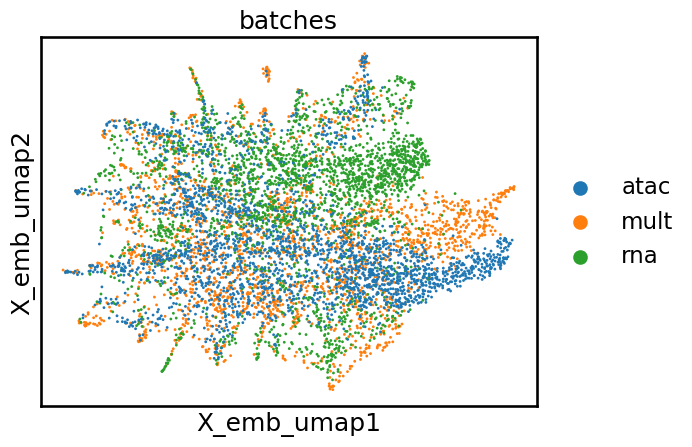

In [21]:
wrap_warn_plot(ad_mosaic, 'X_emb_umap', ['batches'])

### before batch corr

In [24]:
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['batches'],
    label_keys = [],
    use_rep='X_emb', use_neighbors=False,
)
lisi_res['batches_iLISI'][0]

0.5054372179341302

### after batch corr

In [25]:
from batchCorr import HARMONY

ad_mosaic.obsm['X_emb_har'] = HARMONY(pd.DataFrame(ad_mosaic.obsm['X_emb']), ad_mosaic.obs['batches'].to_list())
ad_mosaic = get_umap(ad_mosaic, ['X_emb_har'])
# split_ob([ad_bridge_rna, ad_test1_rna, ad_test2_atac], ad_mosaic, ob='obsm', key='X_emb_har')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).


In [27]:
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['batches'],
    label_keys = [],
    use_rep='X_emb_har', use_neighbors=False,
)
r2 = lisi_res['batches_iLISI'][0]

In [28]:
r2

0.7081893269107242

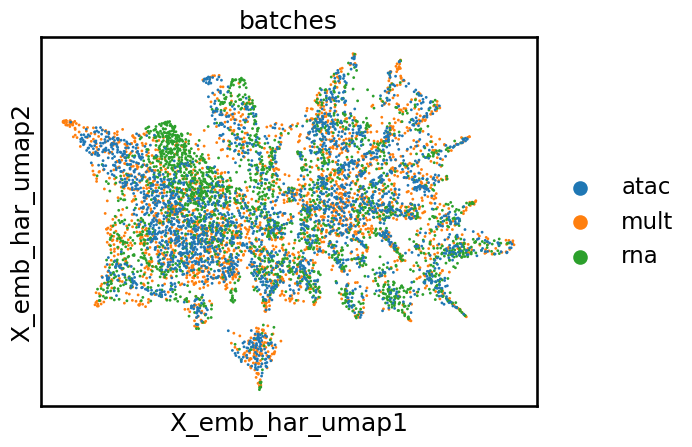

In [29]:
wrap_warn_plot(ad_mosaic, 'X_emb_har_umap', ['batches'])

### Vis

In [31]:
fig_dir = f'/disco_500t/xuhua/gitrepo/BridgeNorm/figures/MB_RNA+ATAC/scmomat'
os.makedirs(fig_dir, exist_ok=True)

df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_mult_rna.obs_names.to_list() + ad_rna.obs_names.to_list() + ad_atac.obs_names.to_list())
df.to_csv(join(fig_dir, 'X_emb.csv'))

df = pd.DataFrame(ad_mosaic.obsm['X_emb_har'], index=ad_mult_rna.obs_names.to_list()+ad_rna.obs_names.to_list()+ad_atac.obs_names.to_list())
df.to_csv(join(fig_dir, 'X_emb_har.csv'))

In [32]:
1

1